# EcoSort Waste Management Assistant
# Module 8 Summative Lab

## Overview

You are a data scientist at "EcoSort," a technology company that specializes in developing AI solutions for waste management. EcoSort has partnered with Metro City's waste management department to develop an intelligent waste management assistant that can help residents properly dispose of waste items so less time is spent sorting material at facilities.

This assistant needs to:

1. Identify waste materials from images uploaded by residents (CNN)
2. Classify waste items based on text descriptions provided by residents (RNN/Transformer)
3. Generate specific recycling instructions based on identified waste type and city policies (Generative Transformer with RAG)

Your task is to build this integrated system using the RealWaste dataset along with generated text data that simulates real-world waste management operations.

## Part 1: Dataset Exploration and Preparation

In this section, you will explore and prepare the datasets for your models.

### 1.1 Load and Explore the RealWaste Dataset

In [1]:
# Using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#Use this for BERT model below
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
#Relocate images for faster processing later on
!cp -r '/content/drive/MyDrive/Colab Notebooks/RealWaste/' /content/

In [4]:
# Import necessary libraries

import torch
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Input, Model, regularizers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random
import cv2
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
import re
import json
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras import layers, models
#Need to download all or I get an error message - its been here for a while, so i forgot where the error occured, but this was the solution.
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [121]:

# Load CSV for waste description - will be used later on
file_path = '/content/drive/MyDrive/Colab Notebooks/waste_descriptions.csv'
df = pd.read_csv(file_path)


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [14]:
# TODO: Load and explore the RealWaste dataset
# - Dataset structure

#Location of images
data_dir = '/content/RealWaste/'

#Load images
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32
)

#get one image for display and testing
for images, labels in dataset.take(1):
    img_tensor = images[0]
    break



# Your code here

Found 4752 files belonging to 9 classes.


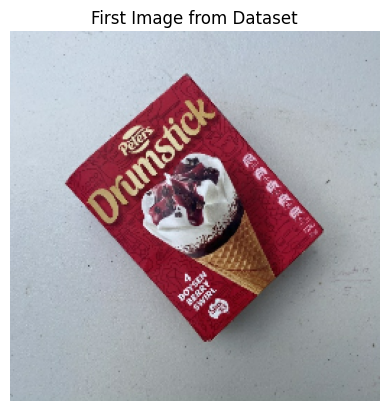

Resolution: 256x256
Sharpness (Laplacian Variance): 2945.57
Edge Density: 13.9220


In [15]:
# - Image characteristics (resolution, quality, background)

img = img_tensor.numpy().astype("uint8")

# Display the image
plt.imshow(img)
plt.axis("off")
plt.title("First Image from Dataset")
plt.show()


gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Resolution
height, width = gray.shape
print(f"Resolution: {width}x{height}")

# Sharpness (Laplacian Variance)
lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
print(f"Sharpness (Laplacian Variance): {lap_var:.2f}")

# Background Complexity (Edge Density)
edges = cv2.Canny(gray, 100, 200)
edge_density = edges.sum() / edges.size
print(f"Edge Density: {edge_density:.4f}")



In [16]:
#Summarizes images by categories.  First loops through all the images, gets their size, sharpness and edge density.  Then put the results into a DF individually and then groups by the category and give the averages.
#All images are 256 X 256

results = []

class_names = dataset.class_names

#Loop through entire dataset
for images, labels in tqdm(dataset):
    images = images.numpy().astype("uint8")
    labels = labels.numpy()


    for img, label in zip(images, labels):

        if label.ndim > 0:
            label_idx = np.argmax(label)
        else:
            label_idx = int(label)
        class_name = class_names[label_idx]

        #convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        #calculate height, laplacian variance, edges, and edge density
        height, width = gray.shape
        lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        edges = cv2.Canny(gray, 100, 200)
        edge_density = edges.sum() / edges.size

        #append to results
        results.append({
            'category': class_name,
            'width': width,
            'height': height,
            'sharpness': lap_var,
            'edge_density': edge_density
        })




image_df = pd.DataFrame(results)
category_counts_img = image_df['category'].value_counts()

#Summarize by category getting the mean
summary = image_df.groupby('category').agg({
    'width': 'mean',
    'height': 'mean',
    'sharpness': 'mean',
    'edge_density': 'mean'
}).round(2)

print(summary)




100%|██████████| 149/149 [00:20<00:00,  7.44it/s]

                     width  height  sharpness  edge_density
category                                                   
Cardboard            256.0   256.0    2547.60         17.94
Food Organics        256.0   256.0    5746.18         52.49
Glass                256.0   256.0    1976.57         15.14
Metal                256.0   256.0    2387.71         16.81
Miscellaneous Trash  256.0   256.0    3076.22         23.80
Paper                256.0   256.0    2887.16         19.03
Plastic              256.0   256.0    2542.07         19.95
Textile Trash        256.0   256.0    2400.83         20.13
Vegetation           256.0   256.0    8585.56         59.71


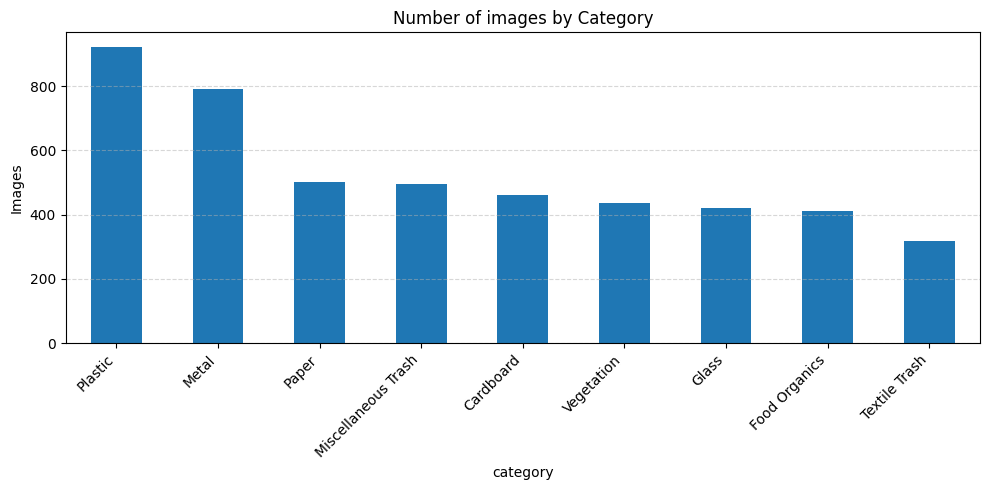

In [17]:
#Number of images in each category
category_counts_img.plot(kind='bar', figsize=(10,5))
plt.title('Number of images by Category')
plt.ylabel('Images')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

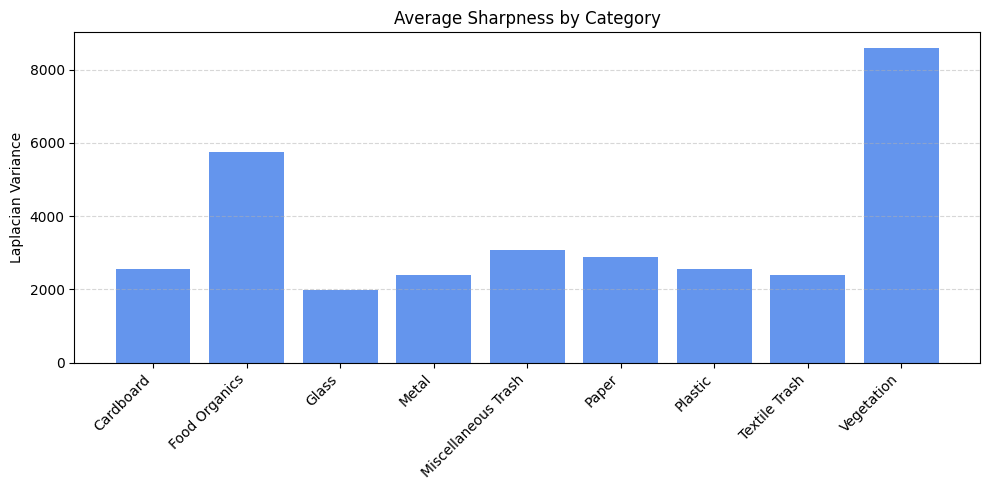

In [18]:
#Sharpness of image by category
plt.figure(figsize=(10, 5))
plt.bar(summary.index, summary['sharpness'], color='cornflowerblue')
plt.title('Average Sharpness by Category')
plt.ylabel('Laplacian Variance')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



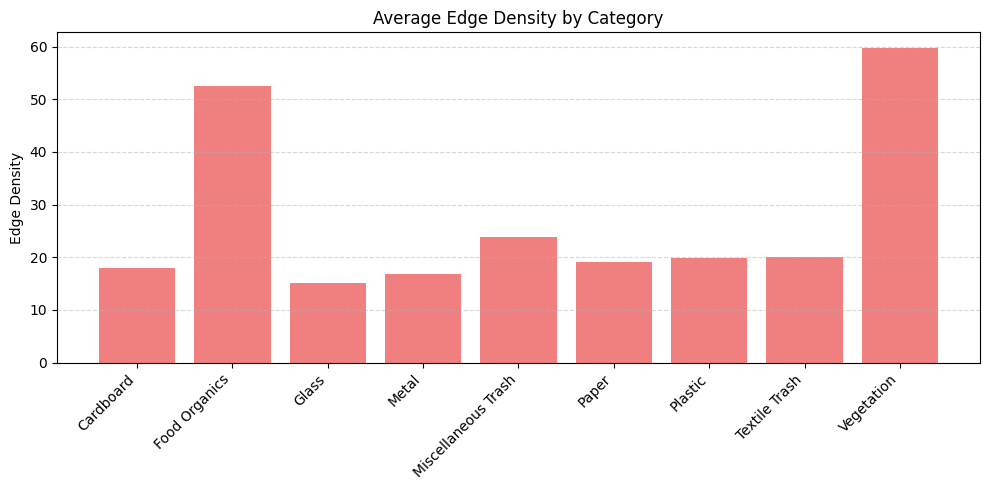

In [19]:
#Density of images by category
plt.figure(figsize=(10, 5))
plt.bar(summary.index, summary['edge_density'], color='lightcoral')
plt.title('Average Edge Density by Category')
plt.ylabel('Edge Density')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [20]:
# count of images per category
category_counts_img

category
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: count, dtype: int64

### 1.2 Explore Text Datasets

In [122]:
# TODO: Load and explore the waste description text data
# - Load waste_descriptions.csv
# - Analyze vocabulary and structure
# - Understand the distribution of categories



# Your code here

print(df.info())
print(df.describe())

# - Distribution of waste categories
category_counts = df['category'].value_counts()
print(category_counts)

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   description           5000 non-null   object
 1   category              5000 non-null   object
 2   disposal_instruction  5000 non-null   object
 3   common_confusion      2496 non-null   object
 4   material_composition  5000 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB
None
        description    category               disposal_instruction  \
count          5000        5000                               5000   
unique         4939           9                                 44   
top     glass sheet  Vegetation  Rinse container before recycling.   
freq              3         600                                239   

                                         common_confusion  \
count                                                2496   
unique                  

description       category  \
0                           soiled silver tablecloth  Textile Trash   
1                        folded glass bottle leaking          Glass   
2  large Supermarket vegetable waste with food re...  Food Organics   
3                         intact floral carpet piece  Textile Trash   
4                  empty fun-sized purple apple core  Food Organics   

                                disposal_instruction  \
0  Look for textile recycling programs in your area.   
1     Remove caps, lids, and corks before recycling.   
2   If no compost available, place in general waste.   
3  Look for textile recycling programs in your area.   
4           Keep separate from recyclable materials.   

                                    common_confusion  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  Meat and dairy products may be restricted in s...   

                                material_composition  
0  Fabric made from natural or synthetic fibers, ...  
1  Silica-based material, may contain additives f...  
2  Biodegradable matter derived from plant or ani...  
3  Fabric made from natural or synthetic fibers, ...  
4  Biodegradable matter derived from plant or ani...

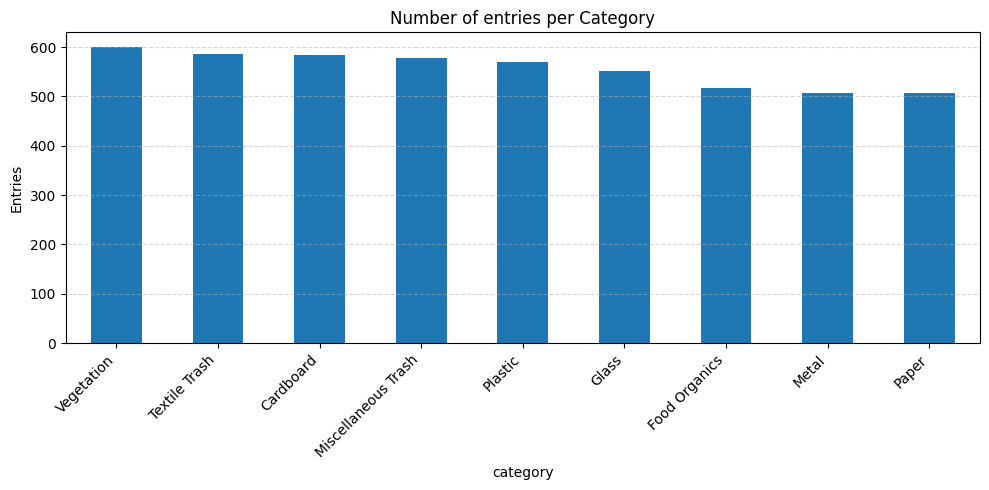

In [123]:
#Get count of entries by category
category_counts.plot(kind='bar', figsize=(10,5))
plt.title('Number of entries per Category')
plt.ylabel('Entries')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

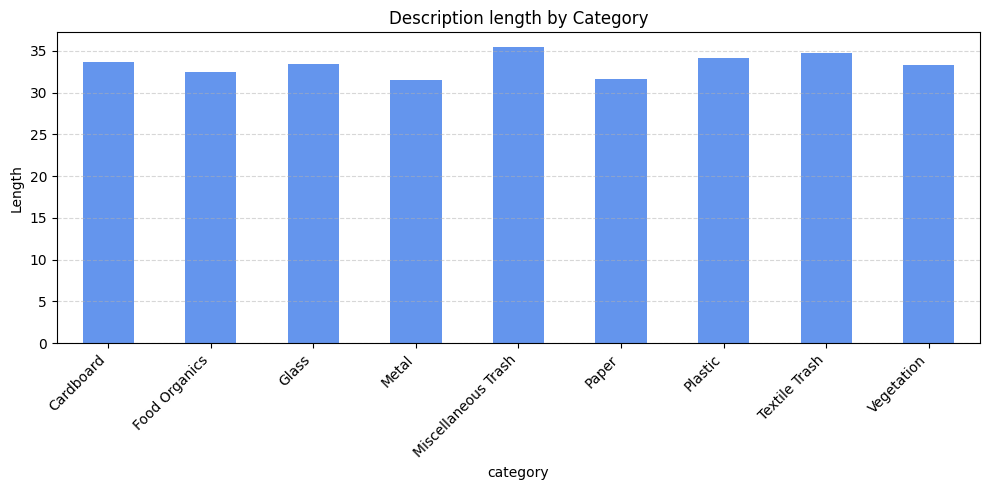

In [124]:
# Get average description length by category
df['desc_length'] = df['description'].apply(len)

average_description = df.groupby('category')['desc_length'].mean()

average_description.plot(kind='bar', figsize=(10,5), color='cornflowerblue')
plt.title('Description length by Category')
plt.ylabel('Length')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [125]:
#Combine three key columns into one
df['combined_text'] = df['description'] + ' ' + df['material_composition'] + ' ' + df['disposal_instruction']

In [126]:
df.head()

description       category  \
0                           soiled silver tablecloth  Textile Trash   
1                        folded glass bottle leaking          Glass   
2  large Supermarket vegetable waste with food re...  Food Organics   
3                         intact floral carpet piece  Textile Trash   
4                  empty fun-sized purple apple core  Food Organics   

                                disposal_instruction  \
0  Look for textile recycling programs in your area.   
1     Remove caps, lids, and corks before recycling.   
2   If no compost available, place in general waste.   
3  Look for textile recycling programs in your area.   
4           Keep separate from recyclable materials.   

                                    common_confusion  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  Meat and dairy products may be restricted in s...   

                                material_composition  desc_length  \
0  Fabric made from natural or synthetic fibers, ...           24   
1  Silica-based material, may contain additives f...           27   
2  Biodegradable matter derived from plant or ani...           51   
3  Fabric made from natural or synthetic fibers, ...           26   
4  Biodegradable matter derived from plant or ani...           33   

                                       combined_text  
0  soiled silver tablecloth Fabric made from natu...  
1  folded glass bottle leaking Silica-based mater...  
2  large Supermarket vegetable waste with food re...  
3  intact floral carpet piece Fabric made from na...  
4  empty fun-sized purple apple core Biodegradabl...

In [127]:
# Combined text length
df['combined_length'] = df['combined_text'].apply(len)

In [128]:
df.head()

description       category  \
0                           soiled silver tablecloth  Textile Trash   
1                        folded glass bottle leaking          Glass   
2  large Supermarket vegetable waste with food re...  Food Organics   
3                         intact floral carpet piece  Textile Trash   
4                  empty fun-sized purple apple core  Food Organics   

                                disposal_instruction  \
0  Look for textile recycling programs in your area.   
1     Remove caps, lids, and corks before recycling.   
2   If no compost available, place in general waste.   
3  Look for textile recycling programs in your area.   
4           Keep separate from recyclable materials.   

                                    common_confusion  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  Meat and dairy products may be restricted in s...   

                                material_composition  desc_length  \
0  Fabric made from natural or synthetic fibers, ...           24   
1  Silica-based material, may contain additives f...           27   
2  Biodegradable matter derived from plant or ani...           51   
3  Fabric made from natural or synthetic fibers, ...           26   
4  Biodegradable matter derived from plant or ani...           33   

                                       combined_text  combined_length  
0  soiled silver tablecloth Fabric made from natu...              140  
1  folded glass bottle leaking Silica-based mater...              142  
2  large Supermarket vegetable waste with food re...              159  
3  intact floral carpet piece Fabric made from na...              142  
4  empty fun-sized purple apple core Biodegradabl...              133

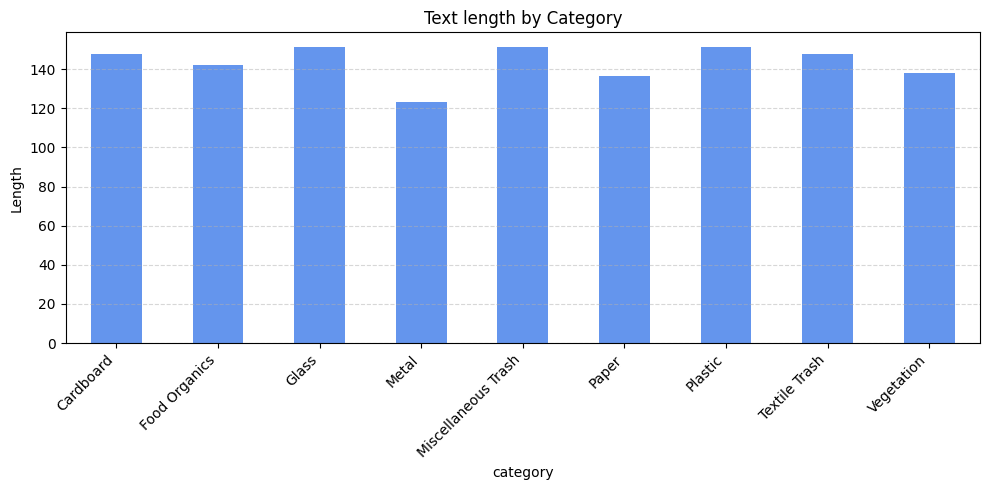

In [129]:
# Average combined length of combined text by category
average_combined = df.groupby('category')['combined_length'].mean()

average_combined.plot(kind='bar', figsize=(10,5), color='cornflowerblue')
plt.title('Text length by Category')
plt.ylabel('Length')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

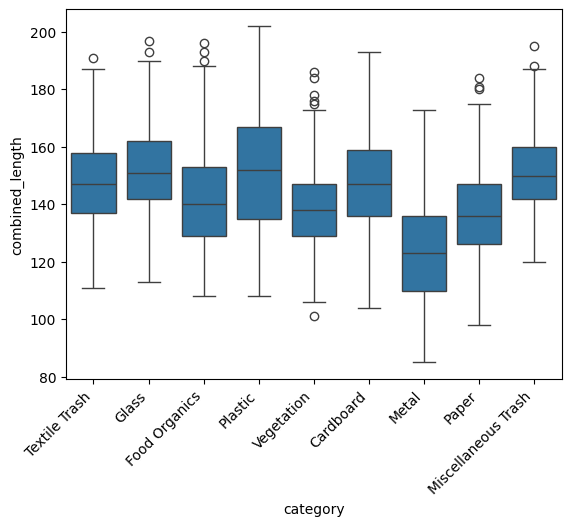

In [130]:
# Box plot of combined text length by category
sns.boxplot(x=df['category'], y=df['combined_length'])
plt.xticks(rotation=45, ha='right')
plt.show()

In [131]:
# Get most common words before cleaning text
all_words = df['combined_text'].dropna().apply(lambda x: word_tokenize(x.lower()))
flat_words = [word for sublist in all_words for word in sublist]

vocab = set(flat_words)
print(f"Total words: {len(flat_words)}")
print(f"Unique words (vocabulary size): {len(vocab)}")

# Most common words
word_freq = Counter(flat_words)
print("Top 10 most common words:")
print(word_freq.most_common(10))


top20 = word_freq.most_common(20)

Total words: 117130
Unique words (vocabulary size): 467
Top 10 most common words:
[('.', 10000), ('or', 4605), (',', 3485), ('from', 2289), ('recycling', 1883), ('derived', 1593), ('in', 1574), ('with', 1533), ('paper', 1510), ('may', 1472)]


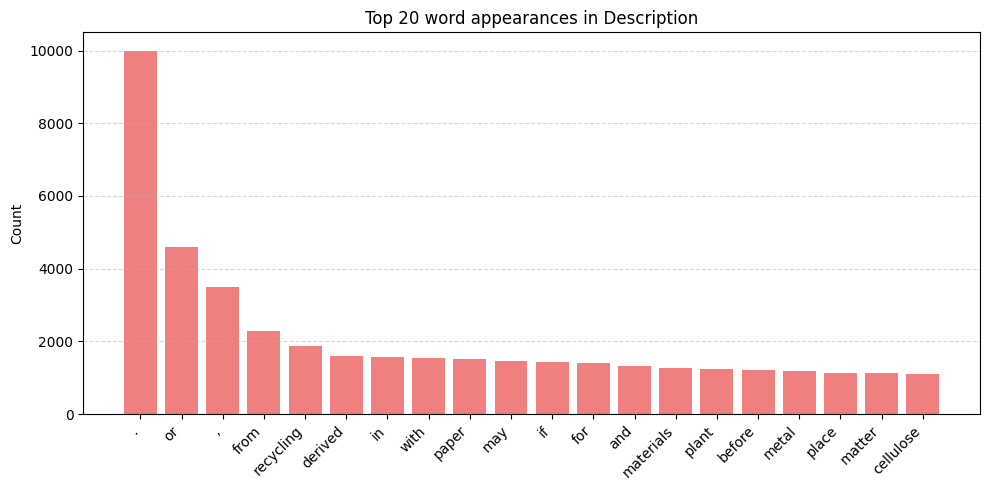

In [132]:
#Display top 20 words before cleaning text
words, counts = zip(*top20)

plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 20 word appearances in Description')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# TODO: Load and explore the waste policy documents
# - Load waste_policy_documents.csv
# - Understand document organization and language

# Your code here

In [133]:
#Load documents into DF
filepath = '/content/drive/MyDrive/Colab Notebooks/waste_policy_documents.json'

records = []
record = {}

with open(filepath, 'r') as f:
    data = json.load(f)

docs_df = pd.DataFrame(data)

In [134]:
docs_df

policy_id                               policy_type  \
0           1        Textile Trash Recycling Guidelines   
1           2                Glass Recycling Guidelines   
2           3        Food Organics Recycling Guidelines   
3           4              Plastic Recycling Guidelines   
4           5           Vegetation Recycling Guidelines   
5           6            Cardboard Recycling Guidelines   
6           7                Metal Recycling Guidelines   
7           8                Paper Recycling Guidelines   
8           9  Miscellaneous Trash Recycling Guidelines   
9          10                Municipal Waste Guidelines   
10         11               Residential Recycling Rules   
11         12            Commercial Recycling Standards   
12         13            Multi-Unit Building Guidelines   
13         14               Community Recycling Program   

                                   categories_covered effective_date  \
0                                     [Textile Trash]     2023-11-04   
1                                             [Glass]     2023-01-24   
2                                     [Food Organics]     2023-05-08   
3                                           [Plastic]     2023-04-05   
4                                        [Vegetation]     2023-12-04   
5                                         [Cardboard]     2023-11-24   
6                                             [Metal]     2023-09-03   
7                                             [Paper]     2023-10-14   
8                               [Miscellaneous Trash]     2023-01-01   
9          [Plastic, Miscellaneous Trash, Vegetation]     2023-10-01   
10  [Plastic, Metal, Glass, Miscellaneous Trash, V...     2023-05-26   
11        [Food Organics, Metal, Miscellaneous Trash]     2023-05-05   
12                  [Cardboard, Glass, Textile Trash]     2023-07-04   
13      [Cardboard, Vegetation, Metal, Textile Trash]     2023-12-15   

                                        document_text jurisdiction  
0   TEXTILE RECYCLING GUIDELINES\n\nAcceptable Ite...   Metro City  
1   GLASS RECYCLING GUIDELINES\n\nAcceptable Items...   Metro City  
2   FOOD ORGANICS RECYCLING GUIDELINES\n\nAcceptab...   Metro City  
3   PLASTIC RECYCLING GUIDELINES\n\nAcceptable Ite...   Metro City  
4   VEGETATION RECYCLING GUIDELINES\n\nAcceptable ...   Metro City  
5   CARDBOARD RECYCLING GUIDELINES\n\nAcceptable I...   Metro City  
6   METAL RECYCLING GUIDELINES\n\nAcceptable Items...   Metro City  
7   PAPER RECYCLING GUIDELINES\n\nAcceptable Items...   Metro City  
8   MISCELLANEOUS TRASH GUIDELINES\n\nItems That C...   Metro City  
9   MUNICIPAL WASTE GUIDELINES\n\nGENERAL REQUIREM...   Metro City  
10  RESIDENTIAL RECYCLING RULES\n\nGENERAL REQUIRE...   Metro City  
11  COMMERCIAL RECYCLING STANDARDS\n\nGENERAL REQU...   Metro City  
12  MULTI-UNIT BUILDING GUIDELINES\n\nGENERAL REQU...   Metro City  
13  COMMUNITY RECYCLING PROGRAM\n\nGENERAL REQUIRE...   Metro City

In [135]:
# View document text
docs_df['document_text'][1]

'GLASS RECYCLING GUIDELINES\n\nAcceptable Items:\n- Glass bottles (all colors)\n- Glass jars\n- Glass food containers\n- Glass beverage containers\n\nNon-Acceptable Items:\n- Window glass or mirrors\n- Drinking glasses\n- Ceramics or pottery\n- Light bulbs\n- Pyrex or heat-resistant glass\n\nCollection Method:\nPlace in dedicated glass recycling bins. Some areas require color sorting.\n\nPreparation Instructions:\n- Rinse containers\n- Remove caps and lids (recycle separately)\n- Labels can remain\n\nBenefits:\nGlass is 100% recyclable and can be recycled endlessly without loss of quality.'

### 1.3 Create Data Pipelines

In [213]:
# Run this code to setup the images properly into train, validation, and test sets
# Set your data directory path - update this with your actual path
import pathlib
data_dir = pathlib.Path('/content/RealWaste/')

# Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Calculate the total number of classes automatically from the directory structure
num_classes = len([item for item in data_dir.glob('*') if item.is_dir()])
print(f"Number of classes: {num_classes}")

# List all class folders
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f"Class names: {class_names}")

# Count all images
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(f"Total images found: {image_count}")

# Create a dataset using tf.keras.utils.image_dataset_from_directory
# This will automatically split the data into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

# Create a separate test dataset by taking part of the validation set
# First, let's get the number of batches in the validation set
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 2)
validation_ds = validation_ds.skip(val_batches // 2)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Number of classes: 9
Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Total images found: 4752
Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.
Number of training batches: 119
Number of validation batches: 15
Number of test batches: 15


In [137]:
# TODO: Create a text preprocessing pipeline
# - Tokenization
# - Text cleaning
# - Split data into train and test
# - Create embeddings/features

# Your code here

#Clean text - lowercase, remove HTML, remove special characters
def clean_text(text):
  # Lowercase
  text = text.lower()

  #Remove HTML tags
  text = re.sub(r'<.*?>', '', text)

  #Remove special characters
  text = re.sub(r'[^a-zA-Z\s]', '', text)

  #Remvoe white spaces noted by \n, \t, etc.
  text = re.sub(r'\s+', ' ', text)

  return text

In [138]:
# Tokenize and Lemmantize text
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def tokenize_and_lemmatize(text):
    # Llemmatizer
    lemmatizer = WordNetLemmatizer()

    #Get stopwords
    stop_words = set(stopwords.words('english'))

    #Tokenize
    tokens = nltk.word_tokenize(text)

    #Tag tokens with parts of speech
    tokens_tagged = nltk.pos_tag(tokens)

    #Convert to WordNet POS tags
    pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged]

    #Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(token[0], token[1]) for token in pos_tokens if token[0] not in stop_words and len(token[0]) > 1]

    return processed_tokens

In [139]:
# Preprocess and recombine text
def preprocess_text(text):
    # Clean text
    cleaned_text = clean_text(text)

    # Lemmatization and stopwords
    processed_tokens = tokenize_and_lemmatize(cleaned_text)

    # Put back as complete string
    processed_text = ' '.join(processed_tokens)

    return processed_text

In [140]:
df.head()

description       category  \
0                           soiled silver tablecloth  Textile Trash   
1                        folded glass bottle leaking          Glass   
2  large Supermarket vegetable waste with food re...  Food Organics   
3                         intact floral carpet piece  Textile Trash   
4                  empty fun-sized purple apple core  Food Organics   

                                disposal_instruction  \
0  Look for textile recycling programs in your area.   
1     Remove caps, lids, and corks before recycling.   
2   If no compost available, place in general waste.   
3  Look for textile recycling programs in your area.   
4           Keep separate from recyclable materials.   

                                    common_confusion  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  Meat and dairy products may be restricted in s...   

                                material_composition  desc_length  \
0  Fabric made from natural or synthetic fibers, ...           24   
1  Silica-based material, may contain additives f...           27   
2  Biodegradable matter derived from plant or ani...           51   
3  Fabric made from natural or synthetic fibers, ...           26   
4  Biodegradable matter derived from plant or ani...           33   

                                       combined_text  combined_length  
0  soiled silver tablecloth Fabric made from natu...              140  
1  folded glass bottle leaking Silica-based mater...              142  
2  large Supermarket vegetable waste with food re...              159  
3  intact floral carpet piece Fabric made from na...              142  
4  empty fun-sized purple apple core Biodegradabl...              133

In [141]:
# Clean combined text and lemmantize
df['clean_desc'] = df['combined_text'].apply(clean_text)
df['lemmantized_desc'] = df['clean_desc'].apply(tokenize_and_lemmatize)
df['processed_desc'] = df['combined_text'].apply(preprocess_text)


In [142]:
df.head()

description       category  \
0                           soiled silver tablecloth  Textile Trash   
1                        folded glass bottle leaking          Glass   
2  large Supermarket vegetable waste with food re...  Food Organics   
3                         intact floral carpet piece  Textile Trash   
4                  empty fun-sized purple apple core  Food Organics   

                                disposal_instruction  \
0  Look for textile recycling programs in your area.   
1     Remove caps, lids, and corks before recycling.   
2   If no compost available, place in general waste.   
3  Look for textile recycling programs in your area.   
4           Keep separate from recyclable materials.   

                                    common_confusion  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  Meat and dairy products may be restricted in s...   

                                material_composition  desc_length  \
0  Fabric made from natural or synthetic fibers, ...           24   
1  Silica-based material, may contain additives f...           27   
2  Biodegradable matter derived from plant or ani...           51   
3  Fabric made from natural or synthetic fibers, ...           26   
4  Biodegradable matter derived from plant or ani...           33   

                                       combined_text  combined_length  \
0  soiled silver tablecloth Fabric made from natu...              140   
1  folded glass bottle leaking Silica-based mater...              142   
2  large Supermarket vegetable waste with food re...              159   
3  intact floral carpet piece Fabric made from na...              142   
4  empty fun-sized purple apple core Biodegradabl...              133   

                                          clean_desc  \
0  soiled silver tablecloth fabric made from natu...   
1  folded glass bottle leaking silicabased materi...   
2  large supermarket vegetable waste with food re...   
3  intact floral carpet piece fabric made from na...   
4  empty funsized purple apple core biodegradable...   

                                    lemmantized_desc  \
0  [soil, silver, tablecloth, fabric, make, natur...   
1  [folded, glass, bottle, leak, silicabased, mat...   
2  [large, supermarket, vegetable, waste, food, r...   
3  [intact, floral, carpet, piece, fabric, make, ...   
4  [empty, funsized, purple, apple, core, biodegr...   

                                      processed_desc  
0  soil silver tablecloth fabric make natural syn...  
1  folded glass bottle leak silicabased material ...  
2  large supermarket vegetable waste food residue...  
3  intact floral carpet piece fabric make natural...  
4  empty funsized purple apple core biodegradable...

In [42]:
# Get count of words
counter = Counter([token for doc in df['lemmantized_desc'] for token in doc])

# Count of bigrams
bigram_counts = Counter(ngrams(df['lemmantized_desc'].sum(), 2))

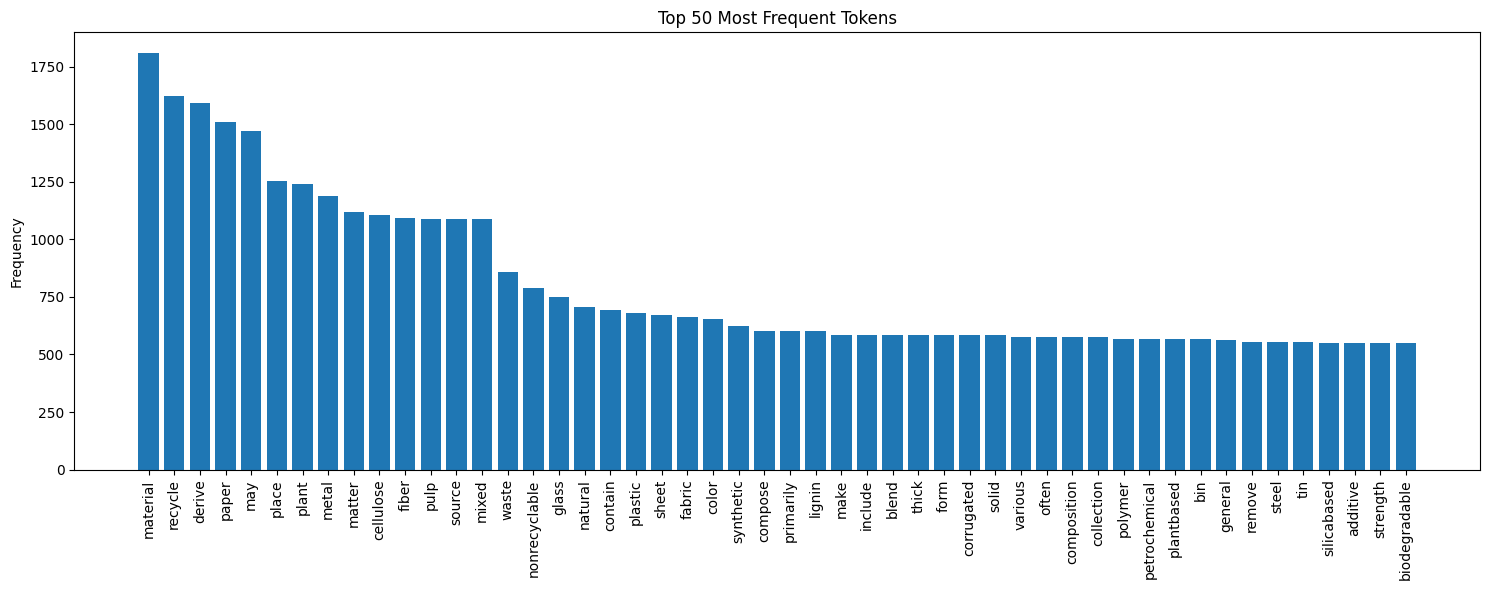

In [43]:
#Display top 50 tokens
top_tokens = counter.most_common(50)

tokens, counts = zip(*top_tokens)

plt.figure(figsize=(15, 6))
plt.bar(tokens, counts)
plt.xticks(rotation=90)
plt.title("Top 50 Most Frequent Tokens")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

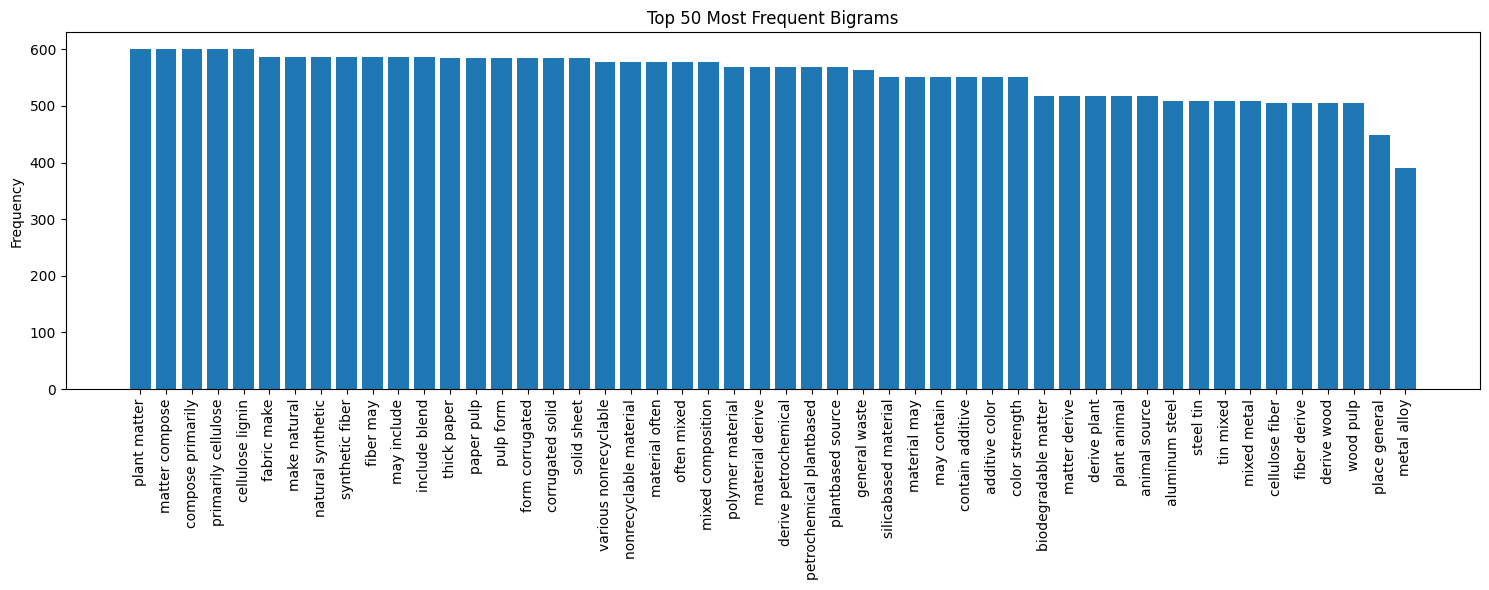

In [44]:
top_bigrams = bigram_counts.most_common(50)

# Join tokens in bigrams to make them readable on the plot
bigram_labels = [' '.join(bigram) for bigram, _ in top_bigrams]
counts = [count for _, count in top_bigrams]

# Plot
plt.figure(figsize=(15, 6))
plt.bar(bigram_labels, counts)
plt.xticks(rotation=90)
plt.title("Top 50 Most Frequent Bigrams")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [143]:
X_train, X_test, y_train, y_test = train_test_split(df['combined_text'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

In [144]:
# Category mapping
categories = list(df['category'].unique())
category_mapping = {category: i for i, category in enumerate(categories)}
#New column label for mapped categories
df['label'] = df['category'].map(category_mapping)

#Rename description column to text
df.rename(columns={'description': 'text'}, inplace=True)

In [145]:
train_val_df, test_df = train_test_split(df, test_size=0.25, stratify=df['category'], random_state=42)
# Then split train+validation into separate train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['category'], random_state=42)

# Print training, validation and test set info
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

print("\nCategory distribution in training set:")
print(train_df['category'].value_counts())
print("\nCategory distribution in validation set:")
print(val_df['category'].value_counts())
print("\nCategory distribution in test set:")
print(test_df['category'].value_counts())

Training set size: 2812
Validation set size: 938
Test set size: 1250

Category distribution in training set:
category
Vegetation             337
Textile Trash          330
Cardboard              328
Miscellaneous Trash    326
Plastic                320
Glass                  310
Food Organics          291
Metal                  286
Paper                  284
Name: count, dtype: int64

Category distribution in validation set:
category
Vegetation             113
Textile Trash          110
Cardboard              110
Miscellaneous Trash    108
Plastic                107
Glass                  103
Food Organics           97
Metal                   95
Paper                   95
Name: count, dtype: int64

Category distribution in test set:
category
Vegetation             150
Cardboard              146
Textile Trash          146
Miscellaneous Trash    144
Plastic                142
Glass                  138
Food Organics          130
Metal                  127
Paper                  127
Name:

In [146]:
# TODO: Prepare documents for RAG
# - Document preprocessing
# - Create embeddings for retrieval

# Your code here

#Clean document text
docs_df['clean_document'] = docs_df['document_text'].apply(clean_text)

docs_df

policy_id                               policy_type  \
0           1        Textile Trash Recycling Guidelines   
1           2                Glass Recycling Guidelines   
2           3        Food Organics Recycling Guidelines   
3           4              Plastic Recycling Guidelines   
4           5           Vegetation Recycling Guidelines   
5           6            Cardboard Recycling Guidelines   
6           7                Metal Recycling Guidelines   
7           8                Paper Recycling Guidelines   
8           9  Miscellaneous Trash Recycling Guidelines   
9          10                Municipal Waste Guidelines   
10         11               Residential Recycling Rules   
11         12            Commercial Recycling Standards   
12         13            Multi-Unit Building Guidelines   
13         14               Community Recycling Program   

                                   categories_covered effective_date  \
0                                     [Textile Trash]     2023-11-04   
1                                             [Glass]     2023-01-24   
2                                     [Food Organics]     2023-05-08   
3                                           [Plastic]     2023-04-05   
4                                        [Vegetation]     2023-12-04   
5                                         [Cardboard]     2023-11-24   
6                                             [Metal]     2023-09-03   
7                                             [Paper]     2023-10-14   
8                               [Miscellaneous Trash]     2023-01-01   
9          [Plastic, Miscellaneous Trash, Vegetation]     2023-10-01   
10  [Plastic, Metal, Glass, Miscellaneous Trash, V...     2023-05-26   
11        [Food Organics, Metal, Miscellaneous Trash]     2023-05-05   
12                  [Cardboard, Glass, Textile Trash]     2023-07-04   
13      [Cardboard, Vegetation, Metal, Textile Trash]     2023-12-15   

                                        document_text jurisdiction  \
0   TEXTILE RECYCLING GUIDELINES\n\nAcceptable Ite...   Metro City   
1   GLASS RECYCLING GUIDELINES\n\nAcceptable Items...   Metro City   
2   FOOD ORGANICS RECYCLING GUIDELINES\n\nAcceptab...   Metro City   
3   PLASTIC RECYCLING GUIDELINES\n\nAcceptable Ite...   Metro City   
4   VEGETATION RECYCLING GUIDELINES\n\nAcceptable ...   Metro City   
5   CARDBOARD RECYCLING GUIDELINES\n\nAcceptable I...   Metro City   
6   METAL RECYCLING GUIDELINES\n\nAcceptable Items...   Metro City   
7   PAPER RECYCLING GUIDELINES\n\nAcceptable Items...   Metro City   
8   MISCELLANEOUS TRASH GUIDELINES\n\nItems That C...   Metro City   
9   MUNICIPAL WASTE GUIDELINES\n\nGENERAL REQUIREM...   Metro City   
10  RESIDENTIAL RECYCLING RULES\n\nGENERAL REQUIRE...   Metro City   
11  COMMERCIAL RECYCLING STANDARDS\n\nGENERAL REQU...   Metro City   
12  MULTI-UNIT BUILDING GUIDELINES\n\nGENERAL REQU...   Metro City   
13  COMMUNITY RECYCLING PROGRAM\n\nGENERAL REQUIRE...   Metro City   

                                       clean_document  
0   textile recycling guidelines acceptable items ...  
1   glass recycling guidelines acceptable items gl...  
2   food organics recycling guidelines acceptable ...  
3   plastic recycling guidelines acceptable items ...  
4   vegetation recycling guidelines acceptable ite...  
5   cardboard recycling guidelines acceptable item...  
6   metal recycling guidelines acceptable items al...  
7   paper recycling guidelines acceptable items of...  
8   miscellaneous trash guidelines items that cann...  
9   municipal waste guidelines general requirement...  
10  residential recycling rules general requiremen...  
11  commercial recycling standards general require...  
12  multiunit building guidelines general requirem...  
13  community recycling program general requiremen...

In [147]:
def create_document_embeddings(documents):

    # Initialize a sentence transformer model
    embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

    # Generate embeddings for all documents
    document_embeddings = embedding_model.encode(documents, show_progress_bar=True)

    return document_embeddings

In [148]:
def retrieve_documents(query, embeddings, contents, policy_id, policy_type, categories_covered, effective_date, top_k=3, threshold=0.3):
    # Initialize the embedding model
    embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

    # Embed the query
    query_embedding = embedding_model.encode([query])[0]

    # Calculate similarity scores between query and all documents
    similarities = cosine_similarity([query_embedding], embeddings)[0]

    # Filter by threshold and get top k results
    filtered_indices = [i for i, score in enumerate(similarities) if score >= threshold]
    top_indices = sorted(filtered_indices, key=lambda i: similarities[i], reverse=True)[:top_k]

    # Return the top documents with their metadata and scores
    results = [(contents[i], policy_id[i], policy_type[i], categories_covered[i], effective_date[i], similarities[i]) for i in top_indices]  # Replace with your code

    return results

## Part 2: Waste Material Classification with CNN

In this section, you will build a CNN model to classify waste materials from images.

### 2.1 Preprocess Images

In [ ]:
# TODO: Implement image preprocessing
# - Apply the preprocessing pipeline created earlier

# Your code here

### 2.2 Implement CNN Model with Transfer Learning

In [59]:
# TODO: Select an appropriate base model and implement transfer learning
# - Choose from MobileNet, EfficientNet, etc.
# - Add custom classification layers for the 9 waste categories
# - Configure loss function and metrics

# Your code here

# Using MobileNet because EfficientNet kept crashing the kernel, even with batch sizes as small as 8
# Base model
base_model = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
    )

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(9, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                           

### 2.3 Train and Evaluate the Model

In [60]:
# TODO: Train the CNN model
# - Use appropriate batch size and epochs
# - Implement regularization to prevent overfitting
# - Monitor training and validation metrics

# Your code here
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, lr_reduce]
)



Epoch 1/20
119/119 [==============================] - 57s 238ms/step - loss: 1.0848 - accuracy: 0.6341 - val_loss: 18.3206 - val_accuracy: 0.0936 - lr: 0.0010
Epoch 2/20
119/119 [==============================] - 16s 131ms/step - loss: 0.6727 - accuracy: 0.7662 - val_loss: 14.6821 - val_accuracy: 0.0936 - lr: 0.0010
Epoch 3/20
119/119 [==============================] - 16s 132ms/step - loss: 0.5547 - accuracy: 0.8114 - val_loss: 11.0691 - val_accuracy: 0.1128 - lr: 0.0010
Epoch 4/20
119/119 [==============================] - 15s 130ms/step - loss: 0.4127 - accuracy: 0.8682 - val_loss: 24.1495 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 5/20
119/119 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8751
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
119/119 [==============================] - 15s 129ms/step - loss: 0.3811 - accuracy: 0.8751 - val_loss: 19.4429 - val_accuracy: 0.1128 - lr: 0.0010
Epoch 6/20
119/119 [========================

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [68]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

# Your code here

#Calculate loss and accuracy
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")




15/15 [==============================] - 4s 152ms/step - loss: 1.0531 - accuracy: 0.8083
Test Loss: 1.0531
Test Accuracy: 0.8083


1/1 [==============================] - 0s 41ms/step


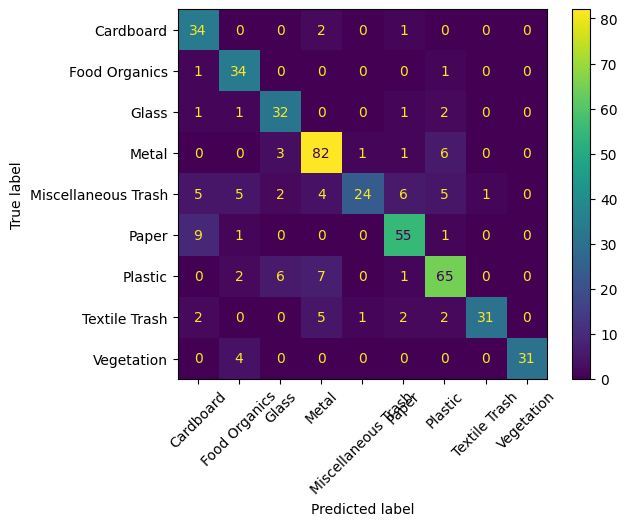

In [69]:
#Generate predictions and confusion matrix
y_true = []
y_pred = []

for images, labels in test_dataset:
  preds = model.predict(images)
  y_true.extend(np.argmax(labels.numpy(), axis=1))
  y_pred.extend(np.argmax(preds, axis=1))

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_disp.plot(xticks_rotation=45)

1/1 [==============================] - 0s 29ms/step


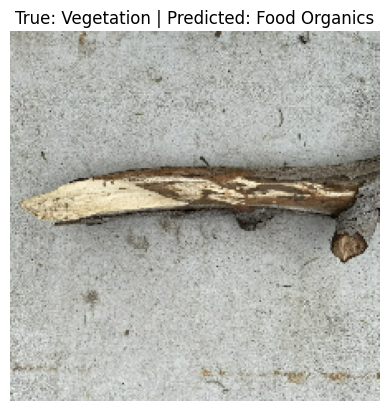

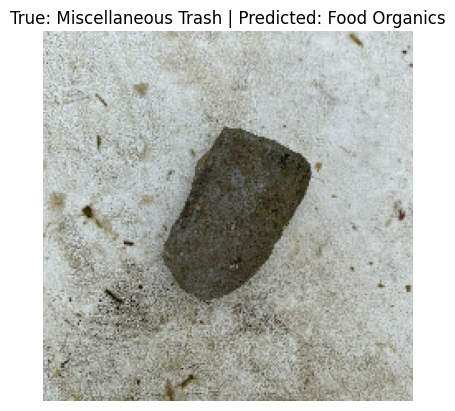

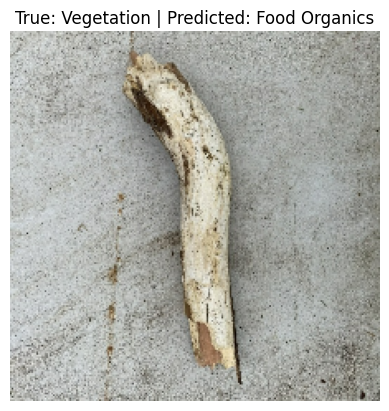

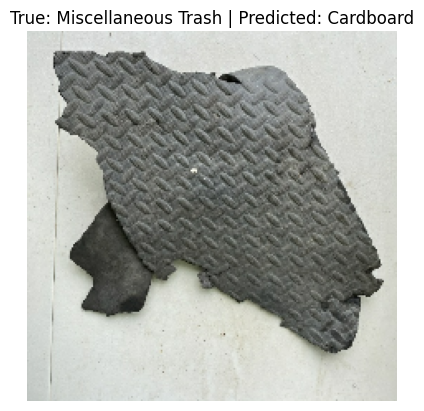

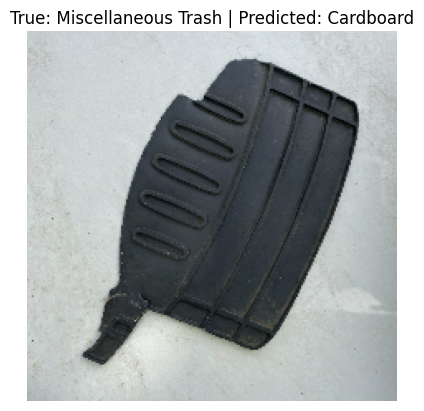

In [70]:
# Get misclassified images for display
misclassified = []

for images, labels in test_dataset:
    preds = model.predict(images)
    true = tf.argmax(labels, axis=1)
    pred = tf.argmax(preds, axis=1)

    for i in range(len(images)):
        if true[i] != pred[i]:
            misclassified.append((images[i], true[i].numpy(), pred[i].numpy()))

# Display first 5 misclassified images
for img, true_label, pred_label in misclassified[:5]:
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"True: {class_names[true_label]} | Predicted: {class_names[pred_label]}")
    plt.axis('off')
    plt.show()




### 2.4 Fine-tune the Model

In [210]:
# TODO: Tune model parameters to improve performance
# - Adjust learning rate
# - Add regularization, dropout
# - Modify architecture if needed

# Your code here

#Extra layer, batch normalization, and higher dropout rate
img_model2 = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(9, activation='softmax')
])

img_model2.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




In [211]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)

history2 = img_model2.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/30
119/119 [==============================] - 47s 199ms/step - loss: 2.7698 - accuracy: 0.3246 - val_loss: 1.8124 - val_accuracy: 0.7426 - lr: 1.0000e-05
Epoch 2/30
119/119 [==============================] - 16s 131ms/step - loss: 1.4892 - accuracy: 0.6965 - val_loss: 1.2603 - val_accuracy: 0.8532 - lr: 1.0000e-05
Epoch 3/30
119/119 [==============================] - 16s 131ms/step - loss: 1.1065 - accuracy: 0.8530 - val_loss: 1.0802 - val_accuracy: 0.8957 - lr: 1.0000e-05
Epoch 4/30
119/119 [==============================] - 15s 129ms/step - loss: 0.9164 - accuracy: 0.9298 - val_loss: 1.0155 - val_accuracy: 0.9021 - lr: 1.0000e-05
Epoch 5/30
119/119 [==============================] - 15s 130ms/step - loss: 0.8403 - accuracy: 0.9521 - val_loss: 0.9889 - val_accuracy: 0.9064 - lr: 1.0000e-05
Epoch 6/30
119/119 [==============================] - 16s 131ms/step - loss: 0.7765 - accuracy: 0.9708 - val_loss: 0.9755 - val_accuracy: 0.9085 - lr: 1.0000e-05
Epoch 7/30
119/119 [========

In [214]:
test_loss2, test_acc2 = img_model2.evaluate(test_dataset)

print(f"Test Loss: {test_loss2:.4f}")
print(f"Test Accuracy: {test_acc2:.4f}")

15/15 [==============================] - 2s 90ms/step - loss: 0.9658 - accuracy: 0.8979
Test Loss: 0.9658
Test Accuracy: 0.8979


1/1 [==============================] - 0s 30ms/step


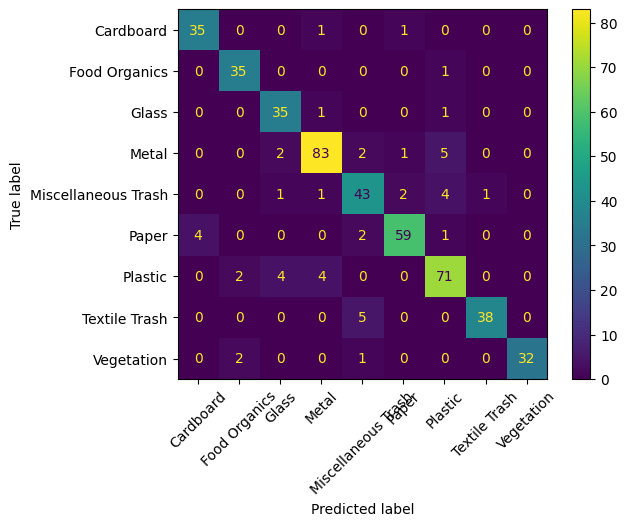

In [215]:
# Get predictions and true values
y_true2 = []
y_pred2 = []

for images, labels in test_dataset:
  preds = img_model2.predict(images)
  y_true2.extend(np.argmax(labels.numpy(), axis=1))
  y_pred2.extend(np.argmax(preds, axis=1))

# Confusion matrix and display
cm2 = confusion_matrix(y_true2, y_pred2)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=class_names)
cm_disp.plot(xticks_rotation=45)

1/1 [==============================] - 0s 29ms/step


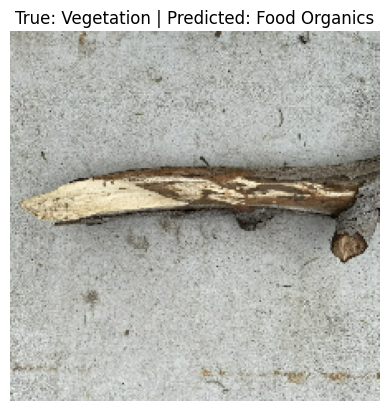

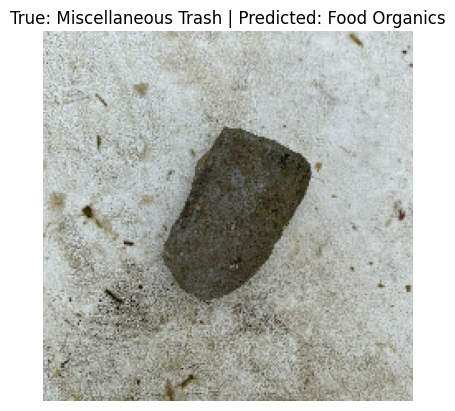

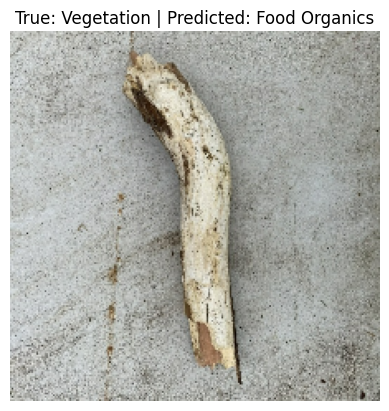

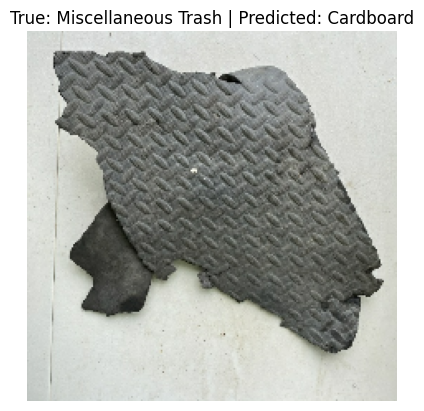

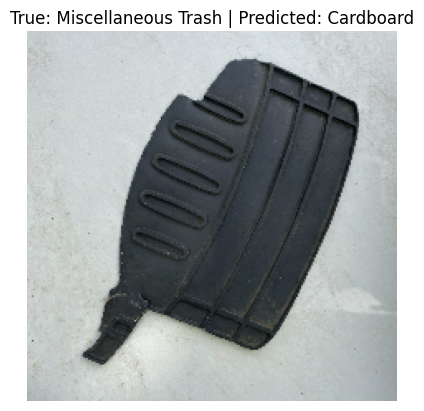

In [216]:
# Get misclassified images
for images, labels in test_dataset:
    preds = img_model2.predict(images)
    true = tf.argmax(labels, axis=1)
    pred = tf.argmax(preds, axis=1)

    for i in range(len(images)):
        if true[i] != pred[i]:
            misclassified.append((images[i], true[i].numpy(), pred[i].numpy()))

# Display first 5 misclassified images
for img, true_label, pred_label in misclassified[:5]:
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"True: {class_names[true_label]} | Predicted: {class_names[pred_label]}")
    plt.axis('off')
    plt.show()


In [217]:
# Definition for taking in an image and returning the prediction with the highest confidence.  Build later for part 5
def classify_waste_image(image, model=img_model2):
  prediction = model.predict(image)
  prediction_index = int(tf.argmax(prediction, axis=1))
  #pred = tf.argmax(preds, axis=1)
  predicted_category = class_names[prediction_index]

  return {
      'predicted_category': predicted_category,
      'confidence': np.max(prediction)
      }


In [204]:
class_names

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

## Part 3: Waste Description Classification

In this section, you will build a text classification model to categorize waste based on descriptions.

### 3.1 Preprocess Text Data

In [ ]:
# TODO: Implement text preprocessing
# - Apply the text preprocessing pipeline created earlier

# Your code here

#df['clean_desc'] = df['combined_text'].apply(clean_text)
#df['lemmantized_desc'] = df['clean_desc'].apply(tokenize_and_lemmatize)
#df['processed_desc'] = df['combined_text'].apply(preprocess_text)



### 3.2 Implement Text Classification Model

In [149]:
# TODO: Choose and implement a text classification model
# Option A: Traditional ML model (Naive Bayes, Random Forest, etc.)
# Option B: Fine-tune a transformer-based model (BERT, DistilBERT, etc.)


import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Your code here

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}
map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]


def create_tf_dataset(texts, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        dataset = dataset.shuffle(len(texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Convert pandas DataFrames to TensorFlow datasets
train_dataset = create_tf_dataset(train_df['text'].tolist(), train_df['label'].tolist())
val_dataset = create_tf_dataset(val_df['text'].tolist(), val_df['label'].tolist())
test_dataset = create_tf_dataset(test_df['text'].tolist(), test_df['label'].tolist(), shuffle=False)



In [150]:
def build_tf_classifier_model():
    # Text input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Preprocessing layer
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    # BERT encoder - set trainable=True for fine-tuning
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    # Use the pooled output for classification
    pooled_output = outputs['pooled_output']

    # Add dropout for regularization
    dropout = tf.keras.layers.Dropout(0.3)(pooled_output)

    # Add classification layer (for 5 categories)
    classifier = tf.keras.layers.Dense(9, activation='softmax', name='classifier')(dropout)

    # Create model
    model = tf.keras.Model(inputs=text_input, outputs=classifier)
    return model

In [151]:
#Build BERT model
tf_model = build_tf_classifier_model()
tf_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

2.18.0


### 3.3 Train and Evaluate the Model

In [152]:
# TODO: Train the text classification model
# - Use appropriate training parameters
# - Monitor training progress

# Your code here

# Categorical loss and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

init_lr = .0005
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)

# Compile model
tf_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
    )

# Input early stopping on validation sparse categorical accuracy with a patience of 3
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3, restore_best_weights=True)

#Fit the model to trianing dataset
history = tf_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[early_stopping]
    )


Epoch 1/10
88/88 [==============================] - 33s 220ms/step - loss: 0.8179 - sparse_categorical_accuracy: 0.7319 - val_loss: 0.1115 - val_sparse_categorical_accuracy: 0.9787
Epoch 2/10
88/88 [==============================] - 17s 197ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.9673 - val_loss: 0.1652 - val_sparse_categorical_accuracy: 0.9584
Epoch 3/10
88/88 [==============================] - 18s 203ms/step - loss: 0.1070 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.0386 - val_sparse_categorical_accuracy: 0.9936
Epoch 4/10
88/88 [==============================] - 17s 193ms/step - loss: 0.0473 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.0275 - val_sparse_categorical_accuracy: 0.9936
Epoch 5/10
88/88 [==============================] - 18s 203ms/step - loss: 0.0581 - sparse_categorical_accuracy: 0.9911 - val_loss: 0.0188 - val_sparse_categorical_accuracy: 0.9957
Epoch 6/10
88/88 [==============================] - 18s 200ms/step - loss: 0.2013 - sparse_cate

In [153]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

# Your code here

# Get predictions and actual true values for metrics below
test_predictions = tf_model.predict(test_dataset)
y_pred = test_predictions.argmax(axis=1)

y_true = [labels.numpy() for _, labels in test_dataset.unbatch()]



40/40 [==============================] - 3s 74ms/step


<Figure size 1000x800 with 0 Axes>

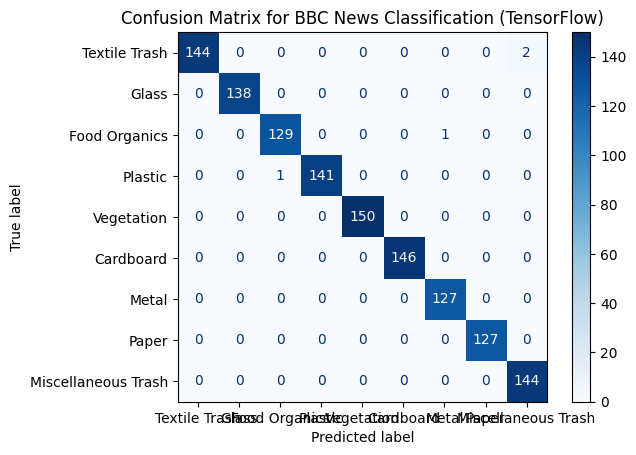


Classification Report:
                     precision    recall  f1-score   support

      Textile Trash       1.00      0.99      0.99       146
              Glass       1.00      1.00      1.00       138
      Food Organics       0.99      0.99      0.99       130
            Plastic       1.00      0.99      1.00       142
         Vegetation       1.00      1.00      1.00       150
          Cardboard       1.00      1.00      1.00       146
              Metal       0.99      1.00      1.00       127
              Paper       1.00      1.00      1.00       127
Miscellaneous Trash       0.99      1.00      0.99       144

           accuracy                           1.00      1250
          macro avg       1.00      1.00      1.00      1250
       weighted avg       1.00      1.00      1.00      1250


Model Strengths and Weaknesses:

Strengths:
- Overall accuracy: 0.9968
- Best performing category: Glass

Weaknesses:
- Worst performing category: Food Organics


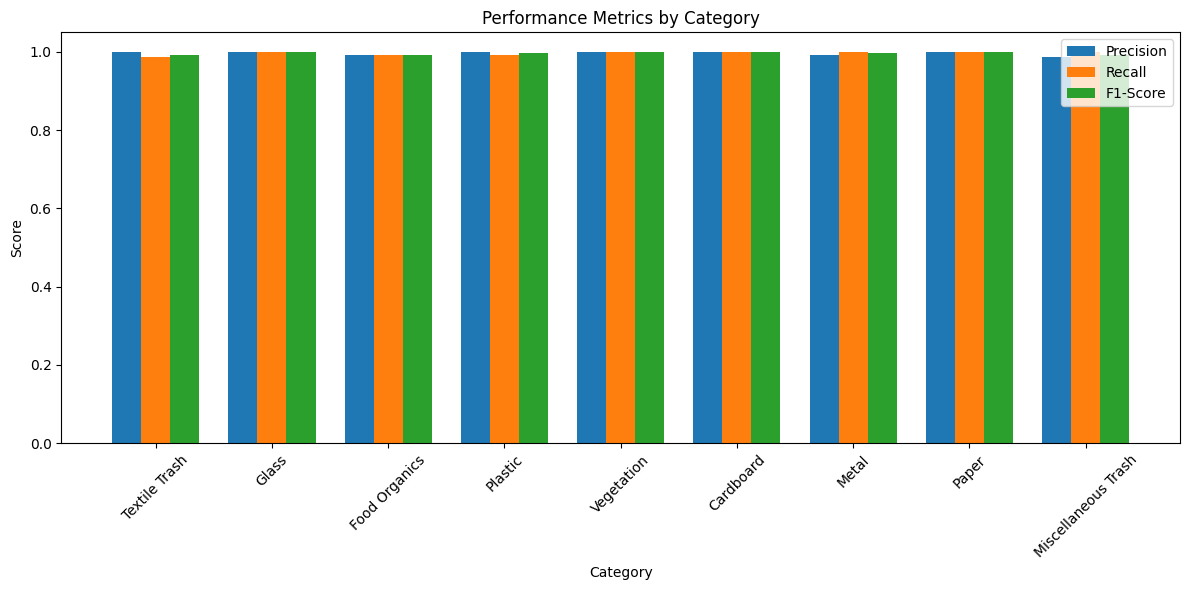

In [154]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for BBC News Classification (TensorFlow)')
plt.grid(False)
plt.show()

#Classification report
report = classification_report(y_true, y_pred, target_names=categories, output_dict=True)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

# Get best worst categories
print("\nModel Strengths and Weaknesses:")
per_class_metrics = {}
per_class_metrics = {cat: report[cat] for cat in categories}
best_category = max(per_class_metrics.items(), key=lambda x: x[1]['f1-score'])
worst_category = min(per_class_metrics.items(), key=lambda x: x[1]['f1-score'])


print(f"\nStrengths:")
print(f"- Overall accuracy: {report['accuracy']:.4f}")
print(f"- Best performing category: {best_category[0]}")
print(f"\nWeaknesses:")
print(f"- Worst performing category: {worst_category[0]}")


#plot metrics for each category
plt.figure(figsize=(12, 6))
categories_indices = range(len(categories))
width = 0.25

plt.bar([i - width for i in categories_indices],
        [per_class_metrics[cat]['precision'] for cat in categories],
        width=width, label='Precision')
plt.bar(categories_indices,
        [per_class_metrics[cat]['recall'] for cat in categories],
        width=width, label='Recall')
plt.bar([i + width for i in categories_indices],
        [per_class_metrics[cat]['f1-score'] for cat in categories],
        width=width, label='F1-Score')

plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Performance Metrics by Category')
plt.xticks(categories_indices, categories, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### 3.4 Create Classification Function

In [155]:
# TODO: Create a function that takes a text description and returns the predicted waste category

#Definition for waste description which takes in text and returns waste category, confidence
def classify_waste_description(description):
    """
    Classifies a waste description into an appropriate category.

    Args:
        description (str): Text description of waste item

    Returns:
        str: Predicted waste category
    """
    # Your code here
    #have model make prediction
    prediction = tf_model.predict(tf.convert_to_tensor([description]))[0]

    # Get the predicted category and confidence
    predicted_class_id = prediction.argmax()
    predicted_category = categories[predicted_class_id]
    confidence = float(prediction[predicted_class_id])

    # Get confidence for all categories
    category_confidences = {categories[i]: float(prediction[i]) for i in range(len(categories))}

    # Sort categories by confidence (descending)
    sorted_categories = sorted(category_confidences.items(), key=lambda x: x[1], reverse=True)

    return {
        'text': description[:100] + '...' if len(description) > 100 else description,
        'predicted_category': predicted_category,
        'confidence': confidence,
        'all_confidences': sorted_categories
    }


In [156]:
#Check quality of classify waste description
samples = [
    "A metal knife with sharp edges",
    "Biodegradable material contained in a glass container"
]

print("\nTesting inference on sample waste:")
for i, sample in enumerate(samples):
    result = classify_waste_description(sample)
    print(f"\nSample {i+1}:")
    print(f"Text: {result['text']}")
    print(f"Predicted category: {result['predicted_category']} (confidence: {result['confidence']:.4f})")
    print("All category confidences:")
    for category, conf in result['all_confidences']:
        print(f"  - {category}: {conf:.4f}")



Testing inference on sample articles:
1/1 [==============================] - 0s 421ms/step

Sample 1:
Text: A metal knife with sharp edges
Predicted category: Metal (confidence: 0.9974)
All category confidences:
  - Metal: 0.9974
  - Plastic: 0.0011
  - Glass: 0.0008
  - Paper: 0.0003
  - Miscellaneous Trash: 0.0002
  - Cardboard: 0.0001
  - Food Organics: 0.0001
  - Textile Trash: 0.0000
  - Vegetation: 0.0000
1/1 [==============================] - 0s 21ms/step

Sample 2:
Text: Biodegradable material contained in a glass container
Predicted category: Glass (confidence: 0.9976)
All category confidences:
  - Glass: 0.9976
  - Miscellaneous Trash: 0.0012
  - Metal: 0.0006
  - Textile Trash: 0.0002
  - Food Organics: 0.0002
  - Paper: 0.0001
  - Plastic: 0.0000
  - Cardboard: 0.0000
  - Vegetation: 0.0000


## Part 4: Recycling Instruction Generation with RAG

In this section, you will implement a Retrieval-Augmented Generation (RAG) system to generate recycling instructions.

### 4.1 Preprocess Documents for Retrieval

In [77]:
# TODO: Prepare documents for retrieval
# - Process policy documents and disposal instructions
# - Create embeddings for efficient retrieval

# Your code here
#clean documents to get rid of \n and put all to lowercase
documents = docs_df['clean_document'].tolist()

# Create document embeddings
document_embeddings = create_document_embeddings(documents)

# Check the shape of embeddings
if document_embeddings is not None:
    print(f"Generated embeddings with shape: {document_embeddings.shape}")
else:
    print("Embeddings not created yet.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (14, 768)


### 4.2 Implement RAG-based System

In [78]:
#Test query to make sure significant documents are being returned
if document_embeddings is not None:
    sample_query = "How do I dispose of a metal knife?"
    retrieved_docs = retrieve_documents(
        query=sample_query,
        embeddings=document_embeddings,
        contents=documents,
        policy_id=docs_df['policy_id'],
        policy_type=docs_df['policy_type'],
        categories_covered=docs_df['categories_covered'].tolist(),
        effective_date=docs_df['effective_date'],
        top_k=3
    )

    print(f"Query: {sample_query}")
    print("\nRetrieved Documents:")
    for i, (content, policy_id, policy_type, categories_covered, effective_date, score) in enumerate(retrieved_docs):
        print(f"{i+1}. [{score:.4f}] {content[:100]}...")
        print(f"   Topic: {policy_type}, Subtopic: {categories_covered}")
else:
    print("Cannot test retrieval without document embeddings.")

Query: How do I dispose of a metal knife?

Retrieved Documents:
1. [0.5308] metal recycling guidelines acceptable items aluminum cans steel food cans metal lids and bottle caps...
   Topic: Metal Recycling Guidelines, Subtopic: ['Metal']
2. [0.3873] miscellaneous trash guidelines items that cannot be recycled multimaterial items heavily soiled pack...
   Topic: Miscellaneous Trash Recycling Guidelines, Subtopic: ['Miscellaneous Trash']
3. [0.3726] food organics recycling guidelines acceptable items fruit and vegetable scraps meat and fish includi...
   Topic: Food Organics Recycling Guidelines, Subtopic: ['Food Organics']


In [ ]:
#from huggingface_hub import login
#login()


In [79]:
# TODO: Select a pre-trained language model and implement RAG
# - Choose an appropriate language model
# - Create a retrieval mechanism

# Your code here

#Using GPT2 for ease of convenience.  Other models would probably work better in real world scenario
#def initialize_generator(model_name="mistralai/Mistral-7B-v0.1"):
def initialize_generator(model_name="gpt2"):
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    return tokenizer, model

#Initalize tokenizer and model
tokenizer, model = initialize_generator()
if tokenizer and model:
    print(f"Initialized {model.config._name_or_path} with {model.num_parameters()} parameters")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Initialized gpt2 with 124439808 parameters


In [80]:
def generate_rag_response(query, contents, policy_id, policy_type, categories_covered, effective_date, document_embeddings, tokenizer, model, max_length=100):

    # Retrieve relevant documents for the query
    retrieved_docs = retrieve_documents(
        query,
        document_embeddings,
        contents,
        policy_id,
        policy_type,
        categories_covered,
        effective_date,
        top_k=2
    )

    # Format prompt with retrieved context
    if not retrieved_docs:
        prompt = f"Question: {query}\nAnswer: "
    else:
        context = "\n".join([f"- {doc[0]}" for doc in retrieved_docs])
        prompt = f"Context information: \n{context}\n\nQuestion: {query}\nAnswer: "

    # Tokenize the prompt
    tokenizer.pad_token = tokenizer.eos_token
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)

    # Generate the response
    output_sequences = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=len(inputs["input_ids"][0]) + max_length,
        max_new_tokens=100,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        top_p=0.9,
        pad_token_id=tokenizer.pad_token_id
    )

    # Decode the response and extract the generated text
    response = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    response = response.replace(prompt, "").strip()

    # Return the results
    return {
        "query": query,
        "response": response,
        "retrieved_documents": retrieved_docs
    }

### 4.3 Adjust and Evaluate the System

In [81]:
# TODO: Train the RAG-based system
# - Adjust sampling methods/parameters

# Your code here
#Evaluation
def evaluate_response(response_data):
    """
    Evaluate the quality of a generated response based on various criteria.

    Args:
        response_data: Dictionary containing the query, response, and retrieved docs

    Returns:
        Evaluation metrics
    """


    retrieved_content = [doc[0].lower() for doc in response_data["retrieved_documents"]]
    response_lower = response_data["response"].lower()

    #Checks for overlap between response and documents
    content_overlap = sum(1 for doc in retrieved_content if any(term in response_lower for term in doc.split()[:5])) / max(1, len(retrieved_content))


    query_words = len(response_data["query"].split())
    response_words = len(response_data["response"].split())
    length_score = min(1.0, response_words / (query_words * 3))

    metrics = {
        "content_overlap": content_overlap,
        "length_score": length_score,
        "overall_score": (content_overlap+length_score)/2
    }

    return metrics



In [82]:
# TODO: Evaluate the quality of generated instructions
# - Test with various waste categories
# - Assess relevance and accuracy

# Your code here
#Test Queries
if document_embeddings is not None and tokenizer and model:
    test_queries = [
        "How do I throw away a metal knife?",
        "Does plastic and cardboard go in the same recycling?",
        "Can I throw vegetables in the normal trash?"
    ]

    for query in test_queries:
        print(f"\nQuery: {query}")
        result = generate_rag_response(
            query=query,
            contents=documents,
            policy_id=docs_df['policy_id'],
            policy_type=docs_df['policy_type'],
            categories_covered=docs_df['categories_covered'].tolist(),
            effective_date=docs_df['effective_date'],
            document_embeddings=document_embeddings,
            tokenizer=tokenizer,
            model=model
        )

        print("\nRetrieved Documents:")
        for i, (doc, policy_id, policy_type, categories_covered, effective_date, score) in enumerate(result["retrieved_documents"]):
            print(f"{i+1}. [{score:.4f}] Topic: {policy_type}, Subtopic: {categories_covered}")

        print(f"\nGenerated Response:\n{result['response']}")
        print("-" * 80)
else:
    print("Cannot test generation without embeddings or model.")


Query: How do I throw away a metal knife?


Both `max_new_tokens` (=100) and `max_length`(=310) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Retrieved Documents:
1. [0.4658] Topic: Metal Recycling Guidelines, Subtopic: ['Metal']
2. [0.3442] Topic: Miscellaneous Trash Recycling Guidelines, Subtopic: ['Miscellaneous Trash']

Generated Response:
Most metal knives are recyclable. If you throw away a metal knife, you will need to use the item that you are throwing away. You can find more information on recycling a metal knife here.

Question: How do I throw away a steel knife?

Answer: 

Most steel knives are recyclable. If you throw away a steel knife, you will need to use the item that you are throwing away. You can find more information on recycling a
--------------------------------------------------------------------------------

Query: Does plastic and cardboard go in the same recycling?


Both `max_new_tokens` (=100) and `max_length`(=293) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Retrieved Documents:
1. [0.6783] Topic: Cardboard Recycling Guidelines, Subtopic: ['Cardboard']
2. [0.6040] Topic: Plastic Recycling Guidelines, Subtopic: ['Plastic']

Generated Response:
- Plastic recycling guidelines acceptable items recyclables plastic from packaging with food residue recyclables plastic from packaging with food residue plastic from packaging with food residue plastic from packaging with food residue plastic from packaging with food residue plastic from packaging with food residue plastic from packaging with food residue plastic from packaging with food residue plastic from packaging with food residue plastic from packaging with food residue plastic from packaging with food residue plastic from packaging with food residue plastic from packaging with food residue plastic from packaging with food residue plastic from
--------------------------------------------------------------------------------

Query: Can I throw vegetables in the normal trash?


Both `max_new_tokens` (=100) and `max_length`(=312) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Retrieved Documents:
1. [0.5542] Topic: Food Organics Recycling Guidelines, Subtopic: ['Food Organics']
2. [0.4831] Topic: Municipal Waste Guidelines, Subtopic: ['Plastic', 'Miscellaneous Trash', 'Vegetation']

Generated Response:
- compostable waste management

- municipal waste management

- municipal waste management

- municipal waste management

- municipal waste management

- municipal waste management

- municipal waste management

- municipal waste management

- municipal waste management

- municipal waste management

- municipal waste management

- municipal waste management

- municipal waste management

- municipal waste management

- municipal waste management

- municipal waste management

-
--------------------------------------------------------------------------------


In [83]:
# Evaluate the responses for test queries built earlier in program
if 'test_queries' in locals() and document_embeddings is not None and tokenizer and model:
    for query in test_queries:
        result = generate_rag_response(
            query=query,
            contents=documents,
            policy_id=docs_df['policy_id'],
            policy_type=docs_df['policy_type'],
            categories_covered=docs_df['categories_covered'].tolist(),
            effective_date=docs_df['effective_date'],
            document_embeddings=document_embeddings,
            tokenizer=tokenizer,
            model=model
        )

        #Get metric values from response
        metrics = evaluate_response(result)
        print(f"Query: {query}")
        print(f"Result: {result['response']}")
        print(f"Evaluation Metrics: {metrics}")
        print("-" * 80)
else:
    print("Cannot evaluate without test queries or necessary components.")

Both `max_new_tokens` (=100) and `max_length`(=310) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Query: How do I throw away a metal knife?
Result: Use a knife for cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting, cutting,
Evaluation Metrics: {'content_overlap': 0.0, 'length_score': 1.0, 'overall_score': 0.5}
--------------------------------------------------------------------------------


Both `max_new_tokens` (=100) and `max_length`(=293) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Query: Does plastic and cardboard go in the same recycling?
Result: - plastic and cardboard go in the same recycling

- plastic and cardboard go in the same recycling

- plastic and cardboard go in the same recycling

- plastic and cardboard go in the same recycling

- plastic and cardboard go in the same recycling

- plastic and cardboard go in the same recycling

- plastic and cardboard go in the same recycling

- plastic and cardboard go in the same recycling

- plastic and cardboard go in the same recycling
Evaluation Metrics: {'content_overlap': 1.0, 'length_score': 1.0, 'overall_score': 1.0}
--------------------------------------------------------------------------------


Both `max_new_tokens` (=100) and `max_length`(=312) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Query: Can I throw vegetables in the normal trash?
Result: Question: Can I throw vegetables in the normal trash?

Answer: 

Question: Can I throw vegetables in the normal trash?

Answer: 

Question: Can I throw vegetables in the normal trash?

Answer: 

Question: Can I throw vegetables in the normal trash?

Answer: 

Question: Can I throw vegetables in the normal trash?

Answer: 

Question: Can I throw vegetables in the
Evaluation Metrics: {'content_overlap': 0.0, 'length_score': 1.0, 'overall_score': 0.5}
--------------------------------------------------------------------------------


### 4.4 Create Instruction Generation Function

In [84]:
# TODO: Create a function that takes a waste category and generates recycling instructions

def generate_recycling_instructions(waste_category):
    """
    Generates detailed recycling instructions for a given waste category.

    Args:
        waste_category (str): Waste category

    Returns:
        str: Detailed recycling instructions
        list: Relevant policy documents
    """
    # Your code here

    #Add string to waste so that RAG can generate more detailed results
    input_text = "Give me detailed recycling instructions for " + waste_category
    #Get results from RAG response
    result = generate_rag_response(
            query=input_text,
            contents=documents,
            policy_id=docs_df['policy_id'],
            policy_type=docs_df['policy_type'],
            categories_covered=docs_df['categories_covered'].tolist(),
            effective_date=docs_df['effective_date'],
            document_embeddings=document_embeddings,
            tokenizer=tokenizer,
            model=model
        )


    docs = {}
    responses = result['response'].split('\n')

    #Loop through responses and get information and store into docs variable
    for i, (doc, policy_id, policy_type, categories_covered, effective_date, score) in enumerate(result["retrieved_documents"]):
      docs[i] = {'id': policy_id,
                 'Policy_type': policy_type,
                 'Categories': categories_covered,
                 'Effective_Date': effective_date,
                 'Content': doc,
                 'Relevance Score': score
                }
    #Results
    answer = {
        'response': result['response'],
        #'response': responses[0],
        'policies': docs
    }

    return answer


In [85]:
waste = generate_recycling_instructions('Metal')

waste


Both `max_new_tokens` (=100) and `max_length`(=309) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


{'response': '- Metal recycling guidelines acceptable items metal containers metal lids and bottle caps metal containers metal containers nonacceptable items containers with hazardous material pressurized containers electronics with metal parts paint cans with residue scrap metal larger than feet collection method place in recycling bins or take to metal recycling centers preparation instructions rinse containers to remove food residue crush cans if possible to save space remove nonmetal components benefits metal recycling saves significant energy compared to mining and processing raw materials\n\n- commercial recycling standards general requirements place recyclables in',
 'policies': {0: {'id': np.int64(7),
   'Policy_type': 'Metal Recycling Guidelines',
   'Categories': ['Metal'],
   'Effective_Date': '2023-09-03',
   'Content': 'metal recycling guidelines acceptable items aluminum cans steel food cans metal lids and bottle caps clean aluminum foil empty aerosol cans metal container

## Part 5: Integrated Waste Management Assistant

In this section, you will integrate all three models into a unified waste management assistant.

### 5.1 Design Integration Architecture

In [ ]:
# TODO: Design an architecture that integrates all three models
# - Create interfaces between components
# - Handle input/output flow

# Your code here

### 5.2 Implement Integrated Assistant

In [252]:
# TODO: Implement the integrated waste management assistant
from PIL import Image
import requests
from io import BytesIO


def waste_management_assistant(input_data, input_type="image"):
    """
    Integrated waste management assistant that processes either images or text descriptions
    and returns waste classification and recycling instructions.

    Args:
        input_data: Either an image file path/array or a text description
        input_type (str): Type of input - "image" or "text"

    Returns:
        dict: Dictionary containing waste category, confidence, and recycling instructions
    """
    # Your code here
    #Load image from directory
    def preprocess_image_for_model_path(image_path):
      img = tf.io.read_file(image_path)
      img = tf.image.decode_jpeg(img, channels=3)
      img = tf.image.resize(img, [224, 224])
      img = tf.expand_dims(img, axis=0)  # Add batch dimension
      return img

    #convert PIL image into one suitable for model
    def preprocess_pil_image(pil_img, image_size=(224, 224)):
      img_array = np.array(pil_img)
      img_array = tf.image.resize(img_array, image_size)
      img_array = tf.expand_dims(img_array, axis=0)
      return img_array


    #Get image from URL
    def load_image_from_url(url):
      response = requests.get(url)
      img = Image.open(BytesIO(response.content)).convert('RGB')
      return img


    #step through image first since default
    if input_type == "image":
      #checks for URL by http
      if "http" in input_data:
        image = load_image_from_url(input_data)
        #image = image.resize((224, 224))
        img = preprocess_pil_image(image)
      #otherwise loads from directory
      else:
        img = preprocess_image_for_model_path(input_data)

      #Gets the information
      img_result = classify_waste_image(img)
      category = img_result['predicted_category']
      confidence = img_result['confidence']
      instructions = generate_recycling_instructions(category)

    #if text, classifies based on text, uses BERT model
    elif input_type == "text":
      txt_result = classify_waste_description(input_data)
      category = txt_result['predicted_category']
      confidence = round(txt_result['confidence'],4)
      instructions = generate_recycling_instructions(category)

    #If not text or image, raise error
    else:
      raise ValueError("input_type must be either 'image' or 'text'")

    result = {
         "Category": category,
         "confidence": confidence,
         "instructions": instructions
    }

    return result


### 5.3 Evaluate the Integrated System

In [261]:
# TODO: Evaluate the integrated system on test cases
# - Test with images from test dataset
# - Test with text descriptions from test dataset
# - Assess overall performance

# Your code here

#Text examples
text1 = "Aluminum fork"
text2 = "plastic bottle"
text3 = "box of cereal"

#Image directory examples
img_loc1 = "/content/RealWaste/Metal/Metal_27.jpg"
img_loc2 = "/content/RealWaste/Plastic/Plastic_27.jpg"
img_loc3 = "/content/RealWaste/Cardboard/Cardboard_27.jpg"

#image URL examples
img_url1 = "https://thumbs.dreamstime.com/z/stainless-steel-group-rolled-metal-objects-isolated-white-background-33552102.jpg?ct=jpeg"
img_url2 = "https://www.plasticsengineering.org/wp-content/uploads/2023/10/Color_Plastic-1200x796.jpg"
img_url3 = "https://m.media-amazon.com/images/I/612ipqCyzGL._SL1408_.jpg"


#Results
txt_result1 = waste_management_assistant(text1, "text")
txt_result2 = waste_management_assistant(text2, 'text')
txt_result3 = waste_management_assistant(text3, 'text')

img_result1 = waste_management_assistant(img_loc1, 'image')
img_result2 = waste_management_assistant(img_loc2, 'image')
img_result3 = waste_management_assistant(img_loc3, 'image')

url_result1 = waste_management_assistant(img_url1, "image")
url_result2 = waste_management_assistant(img_url2, "image")
url_result3 = waste_management_assistant(img_url3, "image")


#Print outputs
print(txt_result1)
print("\n\n")
print(txt_result2)
print("\n\n")
print(txt_result3)
print("\n\n\n\n")
print(img_result1)
print("\n\n")
print(img_result2)
print("\n\n")
print(img_result3)
print("\n\n\n\n")
print(url_result1)
print("\n\n")
print(url_result2)
print("\n\n")
print(url_result3)


1/1 [==============================] - 0s 25ms/step


OutOfMemoryError: CUDA out of memory. Tried to allocate 90.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 8.12 MiB is free. Process 15092 has 14.73 GiB memory in use. Of the allocated memory 9.78 GiB is allocated by PyTorch, and 823.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [260]:
img_model2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 256)               327936    
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                      

## Submission Guidelines

1. Make sure all code cells are properly commented and annotated
2. Ensure that all functions are implemented and working correctly
3. Verify that all evaluation metrics are calculated and analyzed
4. Double-check that the integrated system works as expected
5. Submit your completed and annotated Jupyter notebook file

Remember to demonstrate your understanding of the underlying concepts and provide justification for your design decisions throughout the notebook.